In [1]:
from generate_network import *
from calculate_entropy import *
import numpy as np

In [14]:
G0 = SBM(100, 0.5, 0.1, k = 2)

In [15]:
G1 = G0.copy_graph()
c = G1.get_edge_colors('blue', 'red')

In [16]:
sorts = edge_rankings(G1)

(0.003, 0.005)

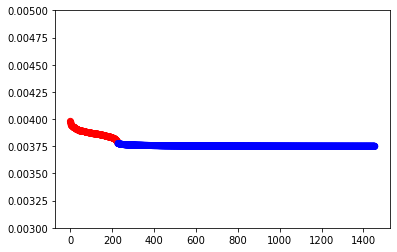

In [20]:
plt.scatter(sorts[1], sorts[0], color = c)
plt.ylim(0.003, 0.005)

In [69]:
G1.get_edge_colors('red', 'blue')

array(['red'], dtype='<U32')

(<Figure size 288x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f88a04c1090>)

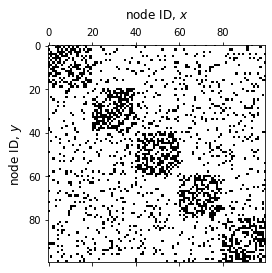

In [70]:
G0.plot_graph()